In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [1]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator
from estimators.particleFilterEstimator import ParticleFilterEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *
from utils.save import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:
# Facultatively load a workspace
workspace_path='workspaces/time_triggered' # None or workspace_path (workspaces/...)

if workspace_path is not None:
    load_workspace(workspace_path, globals())
    print('Wokspace loaded.')
else:
    print('No workspace loaded.')

meanReward_test
measurements_valid
rewards_regular
objectives_train
seeTime
threshold
numberSamples_valid
objectives_test
estimates_test
seeSumAction
T_train
windowSize
T_test
T
meanReward_valid
sigmas_regular
measurements_train
rewards_test
measurements_test
seeEstimate
cost
estimatorType
seeAction
numberSamples_train
objectives_valid
estimates_regular
numberMeasurements
seeMeasurement
T_valid
sigmas_test
Wokspace loaded.


In [3]:
# Set parameters
estimatorType='kalman' # kalman, particle or rnn
generatorType='spring' # spring, tumour or benchmark
seeAction=False
seeMeasurement=True
seeEstimate=False
seeTime=True
seeSumAction=True

T=12+1

threshold=4
windowSize=T


if estimatorType=='kalman':
    cost=50 # tumor_benchmark: 0 < cost=? < ?   classic_benchmark: 0 < cost=50 < 100
elif estimatorType=='particle':
    if seeMeasurement:
        cost=1000 
    else:
        cost=1000 # 0 < cost=? < 1000
elif estimatorType=='rnn':
    cost=500
print("cost=",cost)

cost= 50


In [4]:
if estimatorType=='rnn' and 'model' not in dir(): # if a RNN model has not been loaded
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='linear'#'linear'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,generatorType,numberSamples=numberSamples_trainRNN)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=1-threshold/windowSize)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)
    
    # new
    inputRNN=np.concatenate((np.expand_dims(sigmas_trainRNN,2),measurements_corrupted_trainRNN),axis=2)
    
    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas+1),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    n_epochs_RNN=20
    history=model.fit(x=inputRNN,y=objectives_trainRNN,batch_size=1,epochs=n_epochs_RNN,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
    
    idx_sample=0
    estimates_trainRNN=model.predict(inputRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [5]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(T,windowSize,threshold,model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType=='particle':
    estimator=ParticleFilterEstimator(T,windowSize,threshold,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(T,windowSize,threshold,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

Kalman estimator
  observationsDimensions: [(12, 1), (1,), (1,)]
  seeAction= False
  seeMeasurement= True
  seeEstimate= False
  seeTime= True
  seeCovariance= False
  seeSumAction= True


In [6]:
# contruct rewarder
rewarder=ThresholdRewarder(threshold=threshold, cost=cost, windowSize=windowSize)
rewarder.summarize()

Threshold rewarder
  window size: 13
  threshold: 4
  cost: 50
  number of measures in the window: 0


In [7]:
# generate sequences for training and validating the agent
numberSamples_train=50
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

if workspace_path is None: # data have not been loaded
    (objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
    (objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_valid = objectives_train
#measurements_valid = measurements_train

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

No new data generated
shape training objectives: (50, 13, 1)
shape training measurements: (50, 13, 1)
shape validating objectives: (50, 13, 1)
shape validating measurements: (50, 13, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)

agent._learning_algo.q_vals.summary()

print('Agent constructed')

Environment parameters
  inputDimensions= [(12, 1), (1,), (1,)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 50
  numberSamples_valid 50
Kalman estimator
  observationsDimensions: [(12, 1), (1,), (1,)]
  seeAction= False
  seeMeasurement= True
  seeEstimate= False
  seeTime= True
  seeCovariance= False
  seeSumAction= True
Threshold rewarder
  window size: 13
  threshold: 4
  cost: 50
  number of measures in the window: 0
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 12, 1, 1)     0 

In [9]:
# Train agent
n_epochs_agent=2

agent.resumeTrainingMode() # not required

start_time = time.time()
agent.run(n_epochs=n_epochs_agent, epoch_length=numberSamples_train*T_train)
elapsed_time = time.time() - start_time

cumulatedRewards_valid=agent._controllers[-1].rewards # interleavedValidEpochController is the last controller.
print('Agent Trained (in',elapsed_time,'seconds)')

Instructions for updating:
Use tf.cast instead.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -453.0501604235987 (average over 50 episode(s))
Training epoch 1/2.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -17.533792303133538 (average over 50 episode(s))
Training epoch 2/2.
Agent Trained (in 16.002790689468384 seconds)


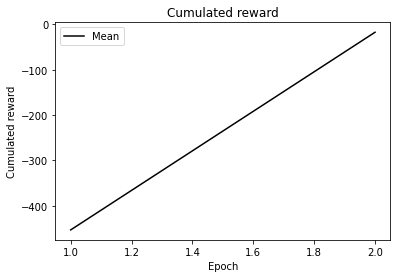

meanReward_valid:  -17.533792303133538


/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting

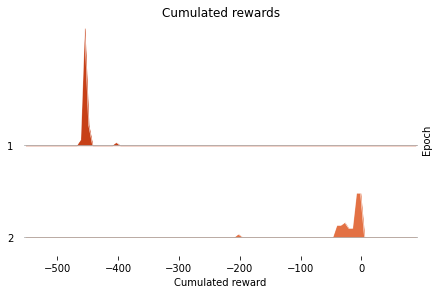

In [10]:
# plot validation
#boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

meanReward_valid=np.mean(cumulatedRewards_valid[-1])
print('meanReward_valid: ',meanReward_valid)

In [11]:
# generate test data
numberSamples_test=numberSamples_train
T_test=T
    
if workspace_path is None: # data have not been loaded
    (objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)
    print('New data generated')
else:
    print('No new data generated')

#print('----- TO REMOVE -----')
#objectives_test = objectives_train
#measurements_test = measurements_train


# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

No new data generated
Test results computed


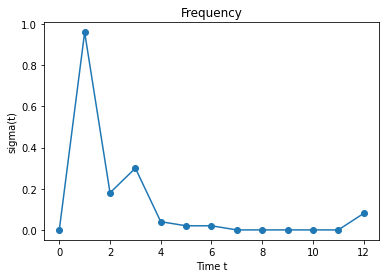

T: 13


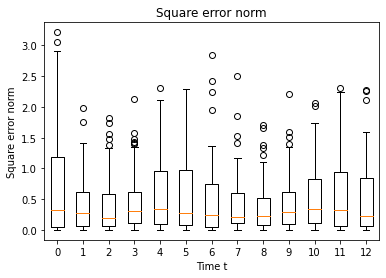

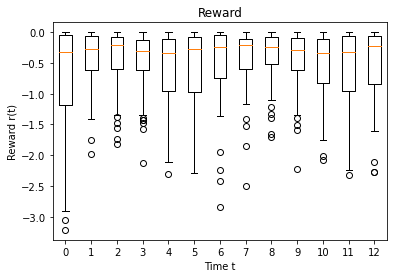

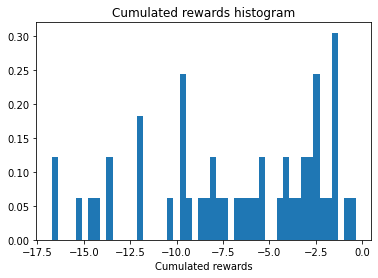

meanReward_test:  -0.5184494012308601
sumSigmas_test [2. 2. 1. 1. 2. 1. 2. 1. 1. 2. 1. 2. 3. 2. 1. 2. 1. 1. 2. 1. 2. 2. 2. 3.
 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 2. 2. 2. 1. 2. 2. 3. 1. 2. 1. 2. 1. 1. 1.
 3. 1.]


In [12]:
# plot test
idx_sample=0
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
#plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
#plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)

meanReward_test=np.mean(rewards_test)
print('meanReward_test: ',meanReward_test)

sumSigmas_test=np.sum(sigmas_test,axis=1)
print('sumSigmas_test',sumSigmas_test)

In [13]:
# regular run on test data (default case without agent)
numberMeasurements=int(np.ceil(threshold/windowSize*T))

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


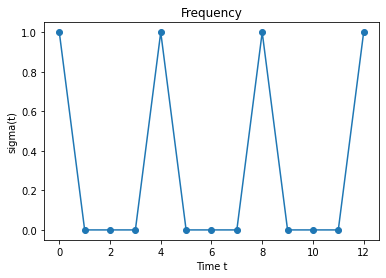

T: 13


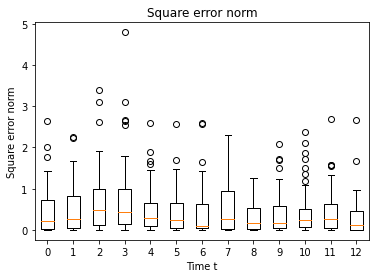

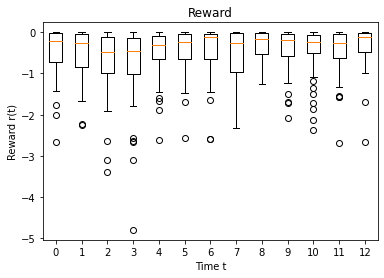

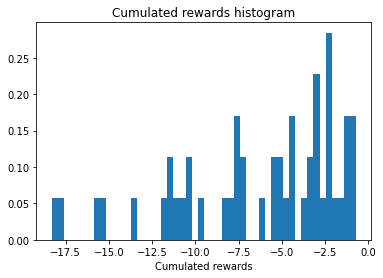

meanReward_regular:  -0.4816050178943067


In [14]:
# plot test regular
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
#plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
#plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)
meanReward_regular=np.mean(rewards_regular)
print('meanReward_regular: ',meanReward_regular)

In [15]:
toSave=["estimatorType","seeAction","seeMeasurement","seeEstimate","seeTime","seeSumAction","T","threshold","windowSize","cost"]
if estimatorType=='rnn':
    toSave.extend(["numberSamples_trainRNN","T_trainRNN","generatorType","objectives_trainRNN","measurements_trainRNN","n_epochs_RNN","model","history","estimates_trainRNN"])
#toSave.extend(["estimator","rewarder"])
toSave.extend(["numberSamples_train","T_train","numberSamples_valid","T_valid","objectives_train","measurements_train","objectives_valid","measurements_valid"])
toSave.extend(["n_epochs_agent"])
toSave.extend(["cumulatedRewards_valid","meanReward_valid"])
toSave.extend(["numberSamples_test","T_test","objectives_test","measurements_test","sigmas_test","rewards_test","estimates_test"])
toSave.extend(["meanReward_test","sumSigmas_test"])
toSave.extend(["numberMeasurements","sigmas_regular","rewards_regular","estimates_regular","meanReward_regular"])
save_workspace('workspaces/',toSave,globals())

estimatorType
seeAction
seeMeasurement
seeEstimate
seeTime
seeSumAction
T
threshold
windowSize
cost
numberSamples_train
T_train
numberSamples_valid
T_valid
objectives_train
measurements_train
objectives_valid
measurements_valid
n_epochs_agent
cumulatedRewards_valid
meanReward_valid
numberSamples_test
T_test
objectives_test
measurements_test
sigmas_test
rewards_test
estimates_test
meanReward_test
sumSigmas_test
numberMeasurements
sigmas_regular
rewards_regular
estimates_regular
meanReward_regular


In [17]:
#import os
#os.system("say Au travail faignant.")

In [18]:
agent.discountFactor()

0.9